# 交叉注意力CrosAttention

In [3]:
import torch
import torch.nn.functional as F
import math
from torch import nn
import unittest


class CrosAttention(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=4):
        super(CrosAttention, self).__init__()
        self._hidden_dim = hidden_dim
        # 输入和输出的维度，点乘
        self.query = nn.Linear(input_dim, hidden_dim)
        self.key = nn.Linear(input_dim, hidden_dim)
        self.value = nn.Linear(input_dim, hidden_dim)

    def forward(self, agent_state, integrate_cluster_emb):
        T, B, A, N = agent_state.shape

        # Cross-attention
        query = self.query(integrate_cluster_emb)       # integrate_cluster_emb作为query
        key = self.key(agent_state)                     # agent_state作为key
        value = self.value(agent_state)                 # agent_state作为value
        # 矩阵点积
        attention_map = torch.matmul(query, key.transpose(-1, -2))  # T, B, 1, A
        attention_map /= math.sqrt(self._hidden_dim)
        attention_map = F.softmax(attention_map, dim=-1)
        # 输出注意力权重，attention_map点乘value向量
        cross_attention_output = torch.matmul(attention_map, value)  # T, B, 1, hidden_dim
        
        return cross_attention_output  # T, B, 1, hidden_dim


  - 前向传播过程：
    - 获取输入 `agent_state` 的形状 `(T, B, A, N)`，其中：
      - `T`: 时间步数。
      - `B`: 批次大小。
      - `A`: 智能体数量。
      - `N`: 每个智能体的特征维度。

In [4]:
class TestCrosAttention(unittest.TestCase):
    def setUp(self):
        self.input_dim = 4
        self.hidden_dim = 4
        self.model = CrosAttention(input_dim=self.input_dim, hidden_dim=self.hidden_dim)

    def test_forward_output_shape(self):
        T, B, A, N = 2, 3, 5, self.input_dim
        agent_state = torch.randn(T, B, A, N)

        integrate_cluster_emb = torch.randn(T, B, 1, N)
        print("agent_state shape is ", agent_state.shape)
        # print("agent_state is \n", agent_state)
        print("integrate_cluster_emb shape is ", integrate_cluster_emb.shape)
        # print("integrate_cluster_emb is \n", integrate_cluster_emb)
        output = self.model(agent_state, integrate_cluster_emb)
        print("output shape is ", output.shape)
        # print("output is \n", output)
        self.assertEqual(output.shape, (T, B, 1, self.hidden_dim))

    def test_forward_attention_behavior(self):
        T, B, A, N = 2, 3, 5, self.input_dim
        agent_state = torch.randn(T, B, A, N)
        integrate_cluster_emb = torch.randn(T, B, 1, N)
        
        output = self.model(agent_state, integrate_cluster_emb)
        # print("model output is \n", output)
        # 验证输出是否在预期范围内
        self.assertTrue(torch.all(output >= 0))
        self.assertTrue(torch.all(output <= 1))
        
        # 验证输出的平均值是否接近0.5（假设均匀分布）
        self.assertTrue(torch.allclose(output.mean(dim=-1), torch.tensor(0.5), atol=0.1))




In [5]:
cross_attention_test = TestCrosAttention()
cross_attention_test.setUp()
cross_attention_test.test_forward_output_shape()

agent_state shape is  torch.Size([2, 3, 5, 4])
integrate_cluster_emb shape is  torch.Size([2, 3, 1, 4])
output shape is  torch.Size([2, 3, 1, 4])


# 自注意力 SelfAttention

In [6]:

class SelfAttention(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=4):
        super(SelfAttention, self).__init__()
        self._hidden_dim = hidden_dim
        self.query = nn.Linear(input_dim, hidden_dim)
        self.key = nn.Linear(input_dim, hidden_dim)
        self.value = nn.Linear(input_dim, hidden_dim)

    def forward(self, agent_state):
        T, B, A, N = agent_state.shape
        # print("agent_state shape is ", agent_state.shape)
        query = self.query(agent_state)
        key = self.key(agent_state)
        value = self.value(agent_state)
        
        attention_map = torch.matmul(query, key.transpose(-1, -2))  # T, B, A, A
        attention_map /= math.sqrt(self._hidden_dim)
        attention_map = F.softmax(attention_map, dim=-1)
        self_attention_output = torch.matmul(attention_map, value)  # T, B, A, hidden_dim
        
        return self_attention_output  # T, B, A, hidden_dim


class TestSelfAttention(unittest.TestCase):
    def setUp(self):
        self.input_dim = 4
        self.hidden_dim = 4
        self.model = SelfAttention(input_dim=self.input_dim, hidden_dim=self.hidden_dim)

    def test_forward_output_shape(self):
        T, B, A = 3, 2, 5
        agent_state = torch.randn(T, B, A, self.input_dim)
        output = self.model(agent_state)
        print("output shape is ", output.shape)
        self.assertEqual(output.shape, (T, B, A, self.hidden_dim))

    def test_forward_output_range(self):
        T, B, A = 3, 2, 5
        agent_state = torch.randn(T, B, A, self.input_dim)
        output = self.model(agent_state)
        print("output is ", output)
        self.assertTrue(output.max() <= 1.0)
        self.assertTrue(output.min() >= -1.0)

    def test_forward_different_hidden_dim(self):
        self.hidden_dim = 8
        self.model = SelfAttention(input_dim=self.input_dim, hidden_dim=self.hidden_dim)
        T, B, A = 3, 2, 5
        agent_state = torch.randn(T, B, A, self.input_dim)
        output = self.model(agent_state)
        self.assertEqual(output.shape, (T, B, A, self.hidden_dim))


In [7]:
self_attention_test = TestSelfAttention()
self_attention_test.setUp()
self_attention_test.test_forward_output_shape()
self_attention_test.test_forward_output_range()

output shape is  torch.Size([3, 2, 5, 4])
output is  tensor([[[[-0.6337,  0.0669, -0.5709,  0.4067],
          [-0.6151,  0.0695, -0.4854,  0.2948],
          [-0.6092,  0.0715, -0.4665,  0.2431],
          [-0.6426,  0.0631, -0.6317,  0.4658],
          [-0.6024,  0.0993, -0.3851,  0.1173]],

         [[-0.3108, -0.3637, -0.3411,  0.2565],
          [-0.3097, -0.1632,  0.0613, -0.0279],
          [-0.3191, -0.3118, -0.2719,  0.1924],
          [-0.3209, -0.3024, -0.2551,  0.1853],
          [-0.2941, -0.2943, -0.1379,  0.1374]]],


        [[[-0.2145, -0.3067, -0.0605,  0.0673],
          [-0.2085, -0.3530, -0.1383,  0.1411],
          [-0.2196, -0.3855, -0.2553,  0.2333],
          [-0.1449, -0.6192, -0.4998,  0.5319],
          [-0.2395, -0.3477, -0.2335,  0.1749]],

         [[-0.3340,  0.2531,  0.7462, -0.5279],
          [-0.3930,  0.2894,  0.6195, -0.4225],
          [-0.4450,  0.3227,  0.5093, -0.3328],
          [-0.3636,  0.2720,  0.6838, -0.4771],
          [-0.4753,  0.3323

单元测试设计
被测方法行为：

- AgentEncoder 类是一个继承自 nn.Module 的 PyTorch 模块，它包含一个编码器，该编码器是一个全连接块（fc_block），用于将输入的 agent_state 转换为隐藏表示。
- ClsEncoder 类也是一个继承自 nn.Module 的 PyTorch 模块，它包含一个编码器，该编码器是一个图卷积网络（GCN），用于将 neigborhood_state 和 edges 转换为隐藏表示。然后，它通过在倒数第二个维度上取平均值来聚合这些表示。

# ClsEncoder簇编码

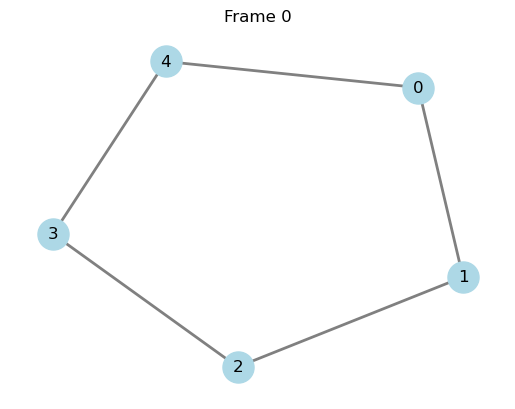

In [8]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# 创建图
G = nx.Graph()
G.add_nodes_from(range(5))
G.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 4), (4, 0)])

# 定义图的布局
pos = nx.spring_layout(G, seed=42)

# 创建图形对象
fig, ax = plt.subplots()

# 定义动画函数
def update(num, G, pos, ax):
    ax.clear()
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, edge_color='gray', width=2, ax=ax)
    ax.set_title(f'Frame {num}')

# 创建动画
ani = animation.FuncAnimation(fig, update, frames=range(10), fargs=(G, pos, ax), repeat=False)

# 将动画转换为 HTML
html_animation = ani.to_jshtml()

# 在 Jupyter Notebook 中显示动画

# HTML(html_animation)


In [9]:
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import unittest

class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

class ClsEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim: int = 4, output_dim: int = 4):
        super(ClsEncoder, self).__init__()
        self._hidden_dim = hidden_dim
        self.encoder = GCN(input_dim, hidden_dim, output_dim)

    def forward(self, neigborhood_state, edges):
        neighborhood_emb = self.encoder(neigborhood_state, edges)
        neighborhood_emb = torch.mean(neighborhood_emb, dim=-2, keepdim=False)
        return neighborhood_emb


In [10]:
import torch
import unittest

class TestClsEncoder(unittest.TestCase):
    def setUp(self):
        # 初始化测试参数
        self.input_dim = 3
        self.hidden_dim = 4
        self.output_dim = 2
        self.num_nodes = 5
        
        # 创建模型实例
        self.model = ClsEncoder(
            input_dim=self.input_dim,
            hidden_dim=self.hidden_dim,
            output_dim=self.output_dim
        )
        
        # 创建测试用图数据
        self.neighborhood_state = torch.randn(self.num_nodes, self.input_dim)
        self.edge_index = torch.tensor([[0,1,2,3,4], [1,2,3,4,0]], dtype=torch.long)

    def test_output_shape(self):
        """测试输出维度是否正确"""
        output = self.model(self.neighborhood_state, self.edge_index)
        print("output shape:", output.shape)
        self.assertEqual(output.shape, (self.output_dim,))

    def test_mean_aggregation(self):
        """测试均值聚合是否正确"""
        # 冻结网络参数
        with torch.no_grad():
            # 将第一层GCN参数置零，bias置1
            self.model.encoder.conv1.lin.weight.zero_()
            self.model.encoder.conv1.bias.fill_(1.0)
            
            # 将第二层GCN参数置零，bias置2
            self.model.encoder.conv2.lin.weight.zero_()
            self.model.encoder.conv2.bias.fill_(2.0)

        # 创建全零输入特征
        test_input = torch.zeros(self.num_nodes, self.input_dim)
        
        # 前向传播
        output = self.model(test_input, self.edge_index)
        print("output shape:", output.shape)
        # 验证输出值全为2.0（ReLU后的bias传播）
        expected = torch.full((self.output_dim,), 2.0)
        self.assertTrue(torch.allclose(output, expected, atol=1e-6))

# if __name__ == "__main__":
#     unittest.main()
if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

..F....
FAIL: test_forward_attention_behavior (__main__.TestCrosAttention.test_forward_attention_behavior)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "C:\Users\Eddie\AppData\Local\Temp\ipykernel_8172\3160695866.py", line 29, in test_forward_attention_behavior
    self.assertTrue(torch.all(output >= 0))
AssertionError: tensor(False) is not true

----------------------------------------------------------------------
Ran 7 tests in 0.058s

FAILED (failures=1)


output shape: torch.Size([2])
output shape: torch.Size([2])
agent_state shape is  torch.Size([2, 3, 5, 4])
integrate_cluster_emb shape is  torch.Size([2, 3, 1, 4])
output shape is  torch.Size([2, 3, 1, 4])
output is  tensor([[[[ 0.1765, -0.0592,  0.0385, -0.5855],
          [ 0.2210, -0.1246,  0.0779, -0.4847],
          [ 0.2076, -0.0896,  0.0671, -0.5318],
          [ 0.2557, -0.1394,  0.1146, -0.4411],
          [ 0.2125, -0.1767,  0.0234, -0.4908]],

         [[-0.1136,  0.1202,  0.0123, -0.6450],
          [-0.1891,  0.0893, -0.0655, -0.6650],
          [-0.1585,  0.0966, -0.0383, -0.6565],
          [-0.1428,  0.0880, -0.0349, -0.6514],
          [-0.0733,  0.1746,  0.0863, -0.6359]]],


        [[[ 0.4210, -0.1777,  0.0815, -0.5438],
          [ 0.6317, -0.3610,  0.0523, -0.5015],
          [-0.1029,  0.1648,  0.0538, -0.6467],
          [ 0.1264,  0.0736,  0.1138, -0.6078],
          [ 0.0287,  0.0894,  0.0699, -0.6213]],

         [[ 0.0789, -0.1828, -0.1155, -0.5854],
       

In [11]:
cls_encoder_test = TestClsEncoder()
cls_encoder_test.setUp()
cls_encoder_test.test_mean_aggregation()
# cls_encoder_test.test_output_shape()

output shape: torch.Size([2])


# fc_block 


 fc_block 函数用于创建一个包含线性层、可选的归一化层、可选的激活函数和可选的丢弃层的全连接块。
 该函数接受以下参数：

- in_channels: 输入张量的通道数。
- out_channels: 输出张量的通道数。
- activation: 一个可选的激活函数。
- norm_type: 归一化类型，可以是 None 或指定的归一化类型。
- use_dropout: 一个布尔值，指示是否使用丢弃层。
- dropout_probability: 丢弃概率，默认为 0.5。
函数根据提供的参数构建一个 nn.Sequential 对象，其中包含线性层、可选的归一化层、可选的激活函数和可选的丢弃层。

分支和所需的测试用例:

- 线性层: 总是存在，因此不需要特定的测试用例。
- 归一化层: 如果 norm_type 不是 None，则包含一个归一化层。需要测试 norm_type 为 None 和非 None 的情况。
- 激活函数: 如果 activation 不是 None，则包含一个激活函数。需要测试 activation 为 None 和非 None 的情况。
- 丢弃层: 如果 use_dropout 为 True，则包含一个丢弃层。需要测试 use_dropout 为 True 和 False 的情况。
- 模拟需求: 不需要模拟，因为该函数不依赖于外部系统或需要模拟的复杂对象。它仅使用 PyTorch 的标准组件。

In [3]:
import sys

sys.path.append(r"C:\Users\Eddie\Documents\marl_sigctrl\framework")

In [4]:
import torch
import torch.nn as nn
from ding.torch_utils.network.nn_module import fc_block


def test_fc_block_NoActivationNoNormNoDropout():
    block = fc_block(in_channels=10, out_channels=20)
    assert len(block) == 1
    assert isinstance(block[0], nn.Linear)
    assert block[0].in_features == 10
    assert block[0].out_features == 20


def test_fc_block_WithActivationNoNormNoDropout():
    block = fc_block(in_channels=10, out_channels=20, activation=nn.ReLU())
    assert len(block) == 2
    assert isinstance(block[0], nn.Linear)
    assert isinstance(block[1], nn.ReLU)


def test_fc_block_NoActivationWithNormNoDropout():
    block = fc_block(in_channels=10, out_channels=20, norm_type='LN')
    assert len(block) == 2
    assert isinstance(block[0], nn.Linear)
    assert isinstance(block[1], nn.LayerNorm)


def test_fc_block_WithActivationWithNormNoDropout():
    block = fc_block(in_channels=10, out_channels=20, activation=nn.ReLU(), norm_type='LN')
    assert len(block) == 3
    assert isinstance(block[0], nn.Linear)
    assert isinstance(block[1], nn.LayerNorm)
    assert isinstance(block[2], nn.ReLU)


def test_fc_block_NoActivationNoNormWithDropout():
    block = fc_block(in_channels=10, out_channels=20, use_dropout=True)
    assert len(block) == 2
    assert isinstance(block[0], nn.Linear)
    assert isinstance(block[1], nn.Dropout)
    assert block[1].p == 0.5


def test_fc_block_WithActivationNoNormWithDropout():
    block = fc_block(in_channels=10, out_channels=20, activation=nn.ReLU(), use_dropout=True)
    assert len(block) == 3
    assert isinstance(block[0], nn.Linear)
    assert isinstance(block[1], nn.ReLU)
    assert isinstance(block[2], nn.Dropout)
    assert block[2].p == 0.5


def test_fc_block_NoActivationWithNormWithDropout():
    block = fc_block(in_channels=10, out_channels=20, norm_type='LN', use_dropout=True)
    assert len(block) == 3
    assert isinstance(block[0], nn.Linear)
    assert isinstance(block[1], nn.LayerNorm)
    assert isinstance(block[2], nn.Dropout)
    assert block[2].p == 0.5


def test_fc_block_WithActivationWithNormWithDropout():
    block = fc_block(in_channels=10, out_channels=20, activation=nn.ReLU(), norm_type='LN', use_dropout=True)
    assert len(block) == 4
    assert isinstance(block[0], nn.Linear)
    assert isinstance(block[1], nn.LayerNorm)
    assert isinstance(block[2], nn.ReLU)
    assert isinstance(block[3], nn.Dropout)
    assert block[3].p == 0.5

d:\Anaconda\Lib\site-packages\treevalue\tree\integration\torch.py:23: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  register_for_torch(TreeValue)
d:\Anaconda\Lib\site-packages\treevalue\tree\integration\torch.py:24: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  register_for_torch(FastTreeValue)


In [5]:
test_fc_block_WithActivationNoNormWithDropout()
test_fc_block_WithActivationWithNormWithDropout()


# AgentEncoder

In [6]:
import torch
import torch.nn as nn
from ding.torch_utils.network.nn_module import fc_block
class AgentEncoder(nn.Module):
    def __init__(self, 
                 input_dim,
                 hidden_dim: int = 4
        ):
        super(AgentEncoder, self).__init__()
        # 如果没有额外的参数，就是一个线性层
        self.encoder = fc_block(input_dim, hidden_dim)
        return 

    def forward(self, agent_state):
        return self.encoder(agent_state)



In [7]:

def test_AgentEncoder_DefaultHiddenDim():
    input_dim = 10
    encoder = AgentEncoder(input_dim)
    assert isinstance(encoder.encoder, nn.Sequential)
    assert len(encoder.encoder) == 1
    assert isinstance(encoder.encoder[0], nn.Linear)
    assert encoder.encoder[0].in_features == input_dim
    assert encoder.encoder[0].out_features == 4  # 默认 hidden_dim 为 4

    # 测试 forward 方法
    input_tensor = torch.randn(1, input_dim)
    output_tensor = encoder(input_tensor)
    assert output_tensor.shape == (1, 4)


def test_AgentEncoder_CustomHiddenDim():
    input_dim = 10
    hidden_dim = 8
    encoder = AgentEncoder(input_dim, hidden_dim)
    assert isinstance(encoder.encoder, nn.Sequential)
    assert len(encoder.encoder) == 1
    assert isinstance(encoder.encoder[0], nn.Linear)
    assert encoder.encoder[0].in_features == input_dim
    assert encoder.encoder[0].out_features == hidden_dim

    # 测试 forward 方法
    input_tensor = torch.randn(1, input_dim)
    output_tensor = encoder(input_tensor)
    assert output_tensor.shape == (1, hidden_dim)


def test_AgentEncoder_DifferentInputDimensions():
    input_dims = [5, 10, 20]
    hidden_dim = 8
    for input_dim in input_dims:
        encoder = AgentEncoder(input_dim, hidden_dim)
        assert isinstance(encoder.encoder, nn.Sequential)
        assert len(encoder.encoder) == 1
        assert isinstance(encoder.encoder[0], nn.Linear)
        assert encoder.encoder[0].in_features == input_dim
        assert encoder.encoder[0].out_features == hidden_dim

        # 测试 forward 方法
        input_tensor = torch.randn(1, input_dim)
        output_tensor = encoder(input_tensor)
        assert output_tensor.shape == (1, hidden_dim)

In [8]:
test_AgentEncoder_DefaultHiddenDim()
test_AgentEncoder_CustomHiddenDim()

# MAVAC test


根据提供的代码片段，`MAVACSota` 类是用于多智能体强化学习（MARL）的模型，继承自 `nn.Module`。以下是对其各个参数的详细解释：

### 初始化参数 (`__init__` 方法)

```python
def __init__(
    self,
    agent_obs_shape: Union[int, SequenceType],
    global_obs_shape: Union[int, SequenceType],
    action_shape: Union[int, SequenceType],
    agent_num: int,
    actor_head_hidden_size: int = 256,
    actor_head_layer_num: int = 2,
    critic_head_hidden_size: int = 512,
    critic_head_layer_num: int = 1,
    action_space: str = 'discrete',
    activation: Optional[nn.Module] = nn.ReLU(),
    norm_type: Optional[str] = None,
    sigma_type: Optional[str] = 'independent',
    bound_type: Optional[str] = None,
) -> None:
```

#### 参数详解

1. **agent_obs_shape**:
   - 类型：`Union[int, SequenceType]`
   - 描述：单个智能体的观测空间形状。可以是一个整数（表示一维观测）或一个序列（表示多维观测）。
   - 作用：用于定义智能体观测的输入维度。

2. **global_obs_shape**:
   - 类型：`Union[int, SequenceType]`
   - 描述：全局观测空间形状。可以是一个整数（表示一维观测）或一个序列（表示多维观测）。
   - 作用：用于定义全局观测的输入维度。

3. **action_shape**:
   - 类型：`Union[int, SequenceType]`
   - 描述：动作空间形状。可以是一个整数（表示离散动作）或一个序列（表示连续动作）。
   - 作用：用于定义动作输出的维度。

4. **agent_num**:
   - 类型：`int`
   - 描述：智能体的数量。
   - 作用：用于确定参与任务的智能体数量。

5. **actor_head_hidden_size**:
   - 类型：`int`
   - 默认值：`256`
   - 描述：Actor 网络头部隐藏层的大小。
   - 作用：控制 Actor 网络中全连接层的神经元数量。

6. **actor_head_layer_num**:
   - 类型：`int`
   - 默认值：`2`
   - 描述：Actor 网络头部层数。
   - 作用：确定 Actor 网络中全连接层的数量。

7. **critic_head_hidden_size**:
   - 类型：`int`
   - 默认值：`512`
   - 描述：Critic 网络头部隐藏层的大小。
   - 作用：控制 Critic 网络中全连接层的神经元数量。

8. **critic_head_layer_num**:
   - 类型：`int`
   - 默认值：`1`
   - 描述：Critic 网络头部层数。
   - 作用：确定 Critic 网络中全连接层的数量。

9. **action_space**:
   - 类型：`str`
   - 默认值：`'discrete'`
   - 描述：动作空间类型，可以是 `'discrete'` 或 `'continuous'`。
   - 作用：确定动作空间是离散还是连续，影响后续网络结构的选择。

10. **activation**:
    - 类型：`Optional[nn.Module]`
    - 默认值：`nn.ReLU()`
    - 描述：激活函数，默认使用 ReLU 激活函数。
    - 作用：应用于网络中的非线性变换。

11. **norm_type**:
    - 类型：`Optional[str]`
    - 默认值：`None`
    - 描述：归一化类型，见 `ding.torch_utils.fc_block` 的更多细节。
    - 作用：用于在网络中添加归一化层，如 BatchNorm、LayerNorm 等。

12. **sigma_type**:
    - 类型：`Optional[str]`
    - 默认值：`'independent'`
    - 描述：在连续动作空间中，用于确定标准差的生成方式。
    - 作用：影响连续动作分布的标准差计算方式。

13. **bound_type**:
    - 类型：`Optional[str]`
    - 默认值：`None`
    - 描述：在连续动作空间中，用于确定动作的边界处理方式。
    - 作用：确保生成的动作在合理的范围内。

### 总结

这些参数共同决定了 `MAVACSota` 模型的结构和行为，包括观测空间、动作空间、网络结构、激活函数等。通过调整这些参数，可以灵活地适应不同的多智能体强化学习任务和环境需求。

`@MODEL_REGISTRY.register('mavac_sota')` 的作用是将 `MAVACSota` 模型类注册到 `MODEL_REGISTRY` 这个全局注册表中，以便后续可以通过名称动态调用和实例化该模型。具体作用如下：

---

### 1. **核心功能**
- **注册模型**  
  通过装饰器语法，将 `MAVACSota` 类与字符串标识符 `'mavac_sota'` 绑定，并存入 `MODEL_REGISTRY`（一个 `Registry` 类的实例）。  
  等价于手动调用：
  ```python
  MODEL_REGISTRY.register(module_name='mavac_sota', module=MAVACSota)
  ```

- **实现解耦**  
  其他代码无需直接导入 `MAVACSota` 类，只需通过 `MODEL_REGISTRY.get('mavac_sota')` 即可获取模型类，实现模块间的解耦。

---

### 2. **Registry 类的作用**
- **统一管理模块**  
  `Registry` 继承自 `dict`，本质是一个字典，存储 `name -> module` 的映射。例如：
  ```python
  MODEL_REGISTRY = Registry()
  # 注册后，MODEL_REGISTRY 的内容变为：
  {'mavac_sota': MAVACSota}
  ```

- **动态构建对象**  
  通过 `build()` 方法，可以根据注册名动态实例化模型：
  ```python
  model = MODEL_REGISTRY.build('mavac_sota', agent_obs_shape=..., global_obs_shape=..., ...)
  ```

---

### 3. **实际应用场景**
- **配置化驱动**  
  在配置文件（如 YAML）中只需指定模型名 `mavac_sota`，代码即可自动加载对应模型：
  ```yaml
  model:
    type: mavac_sota
    args:
      agent_obs_shape: 64
      global_obs_shape: 128
      ...
  ```

- **灵活扩展**  
  新增模型时，只需用 `@MODEL_REGISTRY.register('new_model')` 装饰新类，无需修改其他代码即可集成。

---

### 4. **技术实现细节**
- **装饰器模式**  
  当 `@MODEL_REGISTRY.register('mavac_sota')` 装饰类时，会调用 `Registry.register()` 方法，将类对象存入字典。

- **模块元信息追踪**  
  若启用 `_DI_ENGINE_REG_TRACE_IS_ON`，会记录模型注册的代码位置（文件名和行号），便于调试：
  ```python
  # 查询注册信息
  print(MODEL_REGISTRY.query_details())
  # 输出: OrderedDict([('mavac_sota', ('path/to/file.py', 123))])
  ```

---

### 5. **与代码的关联**
在 `MAVACSota` 的定义中：
```python
@MODEL_REGISTRY.register('mavac_sota')
class MAVACSota(nn.Module):
    ...
```
- **`MODEL_REGISTRY`** 是一个全局注册表实例。
- **`register`** 方法将类名 `'mavac_sota'` 和类对象 `MAVACSota` 绑定。

---

### 总结
通过 `@MODEL_REGISTRY.register('mavac_sota')`，模型 `MAVACSota` 被注册到一个中央仓库中，后续可以通过字符串 `'mavac_sota'` 动态获取并实例化该模型。这种设计模式广泛应用于深度学习框架（如 Detectron2、MMDetection），以实现高度模块化和可配置化。

In [9]:
import torch
import unittest
from ding.model.template import MAVACSota
from ding.torch_utils import to_tensor


In [10]:
class TestMAVACSota(unittest.TestCase):
    def setUp(self):
        self.agent_obs_shape = 3
        self.global_obs_shape = 9
        self.action_shape = 2
        self.agent_num = 4
        self.action_space = 'discrete'

    def test_compute_actor_discrete(self):
        model = MAVACSota(
            self.agent_obs_shape, self.global_obs_shape, self.action_shape, self.agent_num, action_space='discrete'
        )
        inputs = {
            'agent_state': torch.randn(4, self.agent_obs_shape),
            'action_mask': torch.ones(4, self.action_shape)
        }
        actor_outputs = model(inputs, 'compute_actor')
        print("actor_outputs shape ", actor_outputs['logit'].shape)
        self.assertEqual(actor_outputs['logit'].shape, torch.Size([4, self.action_shape]))

    def test_compute_actor_continuous(self):
        model = MAVACSota(
            self.agent_obs_shape, self.global_obs_shape, self.action_shape, self.agent_num, action_space='continuous'
        )
        inputs = {
            'agent_state': torch.randn(4, self.agent_obs_shape),
            'action_mask': torch.ones(4, self.action_shape)
        }
        actor_outputs = model(inputs, 'compute_actor')
        self.assertEqual(actor_outputs['logit'].shape, torch.Size([4, self.action_shape]))

    def test_compute_critic_sota(self):
        model = MAVACSota(
            self.agent_obs_shape, self.global_obs_shape, self.action_shape, self.agent_num, sota=True
        )
        inputs = {
            'agent_state': torch.randn(4, self.agent_obs_shape),
            'cls_state': torch.randn(4, self.agent_obs_shape),
            'global_state': torch.randn(4, self.global_obs_shape)
        }
        critic_outputs = model(inputs, 'compute_critic')
        self.assertEqual(critic_outputs['value'].shape, torch.Size([4]))

    def test_compute_critic_non_sota(self):
        model = MAVACSota(
            self.agent_obs_shape, self.global_obs_shape, self.action_shape, self.agent_num, sota=False
        )
        inputs = {
            'agent_state': torch.randn(4, self.agent_obs_shape),
            'cls_state': torch.randn(4, self.agent_obs_shape),
            'global_state': torch.randn(4, self.global_obs_shape)
        }
        critic_outputs = model(inputs, 'compute_critic')
        self.assertEqual(critic_outputs['value'].shape, torch.Size([4]))

    def test_compute_actor_critic(self):
        model = MAVACSota(
            self.agent_obs_shape, self.global_obs_shape, self.action_shape, self.agent_num, action_space='discrete'
        )
        inputs = {
            'agent_state': torch.randn(4, self.agent_obs_shape),
            'cls_state': torch.randn(4, self.agent_obs_shape),
            'global_state': torch.randn(4, self.global_obs_shape),
            'action_mask': torch.ones(4, self.action_shape)
        }
        outputs = model(inputs, 'compute_actor_critic')
        self.assertEqual(outputs['logit'].shape, torch.Size([4, self.action_shape]))
        self.assertEqual(outputs['value'].shape, torch.Size([4]))


In [11]:
mavac_sota_test = TestMAVACSota()

In [13]:
mavac_sota_test.setUp()
mavac_sota_test.test_compute_actor_continuous()

AttributeError: 'dict' object has no attribute 'shape'